In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [11]:
chosen_stocklist = pd.read_csv("TRD_Mnth.csv")
chosen_stocklist["Trddt"] = pd.to_datetime(chosen_stocklist["Trdmnt"], format="%Y-%m")
chosen_stocklist

,Stkcd,Trdmnt,Mretwd,Trddt
0,600010,2020-01,-0.053030,2020-01-01
1,600010,2020-02,-0.064000,2020-02-01
2,600010,2020-03,-0.017094,2020-03-01
3,600010,2020-04,-0.060870,2020-04-01
4,600010,2020-05,0.018518,2020-05-01
...,...,...,...,...
3235,603915,2024-08,-0.091205,2024-08-01
3236,603915,2024-09,0.278375,2024-09-01
3237,603915,2024-10,-0.060387,2024-10-01
3238,603915,2024-11,0.231621,2024-11-01


In [12]:
def best_10_of_predictions(filename):
    predictions = pd.read_csv(filename)
    predictions = predictions.sort_values('Prediction', ascending=False)
    bestcode = predictions.head(10)["Stock"].reset_index(drop=True)
    return bestcode

In [13]:
def return_information_calculation(bestcode,filedate):
    best_returns = pd.DataFrame()
    for code in bestcode:
        returns= list(chosen_stocklist.loc[(chosen_stocklist["Stkcd"] == code) & (chosen_stocklist["Trddt"] >= (filedate - pd.DateOffset(years=1))) 
                & (chosen_stocklist["Trddt"] <= filedate), "Mretwd"])
        returns = pd.DataFrame(returns).T
        best_returns = pd.concat([best_returns, returns], axis=0)
    best_returns.index = bestcode
    expected_returns = best_returns.mean(axis=1)  
    std_dv = best_returns.std(axis=1)   
    correlation_matrix = best_returns.T.corr()
    return expected_returns, std_dv, correlation_matrix

In [14]:
def draw_heatmap_correlation(filedate, correlation_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
    plt.title('Correlation Matrix Heatmap')
    plt.savefig("output/"+ str(filedate.date()) + "_heatmap.png")

In [15]:
# 定义目标函数：投资组合的波动率
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

# 定义目标函数：负的夏普比率
def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.0):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

In [16]:
def montecarlo_results_and_two_weights(filedate, std_dv, correlation_matrix, expected_returns, bestcode):
    # 计算协方差矩阵
    cov_matrix = np.diag(std_dv) @ correlation_matrix @ np.diag(std_dv)
        
    # 蒙特卡洛模拟参数
    num_simulations = 100000
    results = np.zeros((3, num_simulations))

    # 模拟
    num_assets = 10
    for i in range(num_simulations):
        # 生成随机权重
        weights = np.random.exponential(scale=1.0, size=num_assets)
        weights /= np.sum(weights)
        
        # 计算投资组合的预期收益率和风险
        portfolio_return = np.dot(weights, expected_returns)
        p_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        
        # 存储结果
        results[0, i] = portfolio_return
        results[1, i] = p_volatility
        results[2, i] = -negative_sharpe_ratio(weights, expected_returns, cov_matrix)

    # 约束条件：权重之和为1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # 权重的边界：每个权重在0到1之间
    bounds = tuple((0, 1) for _ in range(num_assets))

    # 初始权重
    initial_weights = np.ones(num_assets) / num_assets

    # 最小风险组合
    min_vol_result = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    min_vol_weights = min_vol_result.x
    min_vol_return = np.dot(min_vol_weights, expected_returns)
    min_vol_volatility = np.sqrt(min_vol_weights.T @ cov_matrix @ min_vol_weights)
   
    # 最大夏普比率组合
    max_sharpe_result = minimize(negative_sharpe_ratio, initial_weights, args=(expected_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
    max_sharpe_weights = max_sharpe_result.x
    max_sharpe_return = np.dot(max_sharpe_weights, expected_returns)
    max_sharpe_volatility = np.sqrt(max_sharpe_weights.T @ cov_matrix @ max_sharpe_weights)

    # 绘制有效前沿图，并标注最小风险组合和最大夏普比率组合
    plt.figure(figsize=(9, 6))
    plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap="Blues", alpha=0.8)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(min_vol_volatility, min_vol_return, color='purple', marker='*', s=200, label='Minimum Volatility Portfolio')
    plt.scatter(max_sharpe_volatility, max_sharpe_return, color='blue', marker='*', s=200, label='Maximum Sharpe Ratio Portfolio')
    plt.xlabel('Portfolio Volatility')
    plt.ylabel('Portfolio Return')
    plt.title('Efficient Frontier of adjustment date: ' + str(filedate.date()))
    plt.legend(loc="lower right")
    plt.savefig("output/"+ str(filedate.date()) + "_frontier.png")

    # 输出最小风险组合和最大夏普比率组合的权重
    total_weights = pd.concat([pd.DataFrame(bestcode),pd.DataFrame(min_vol_weights)], axis=1)
    total_weights = pd.concat([total_weights,pd.DataFrame(max_sharpe_weights)], axis=1)
    total_weights.columns = ["Stkcd", "Min Volatility weight", "Max Sharpe Ratio weight"]
    total_weights.to_excel("output/"+ str(filedate.date()) + "_weights.xlsx", index=False)

In [17]:
def run_adjustment_efficient_frontier(filenames):
    for filename in filenames:
        bestcode = list(best_10_of_predictions(filename))
        filedate = pd.to_datetime(filename.split(".")[0], format='%Y%m%d')
        filedate = filedate - pd.DateOffset(days=filedate.day-1)
        expected_returns, std_dv, correlation_matrix = return_information_calculation(bestcode, filedate)
        draw_heatmap_correlation(filedate, correlation_matrix)
        montecarlo_results_and_two_weights(filedate, std_dv, correlation_matrix, expected_returns, bestcode)
        print("Adjustment date of "+ str(filedate.date()) + ": Done")

Adjustment date of 2023-01-01: Done
Adjustment date of 2023-04-01: Done
Adjustment date of 2023-07-01: Done
Adjustment date of 2023-10-01: Done
Adjustment date of 2024-01-01: Done
Adjustment date of 2024-04-01: Done
Adjustment date of 2024-07-01: Done
Adjustment date of 2024-10-01: Done


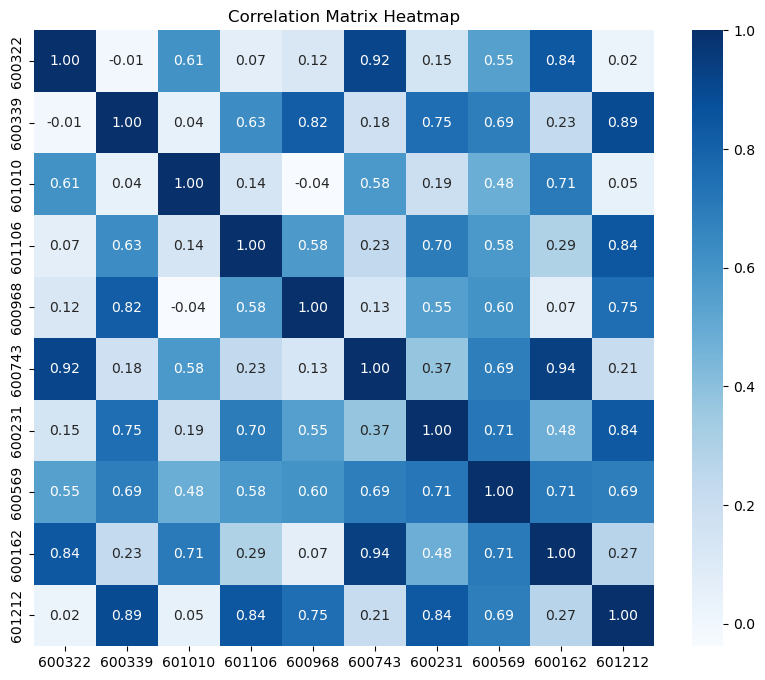

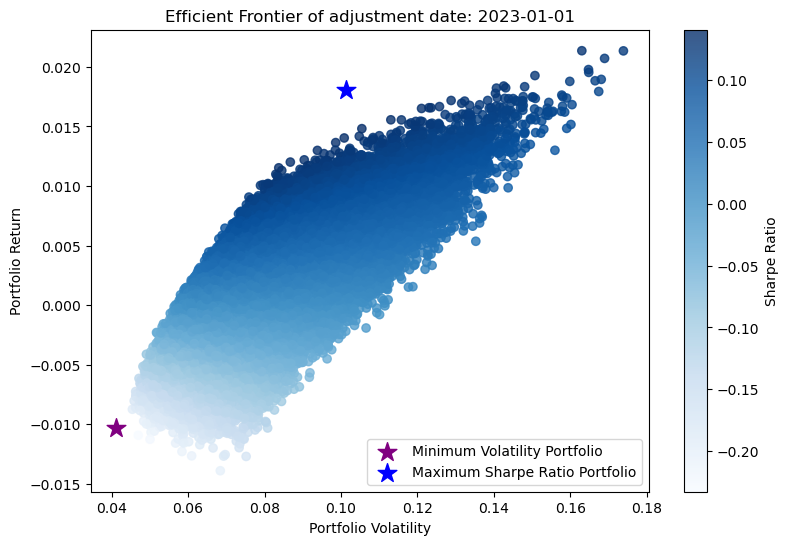

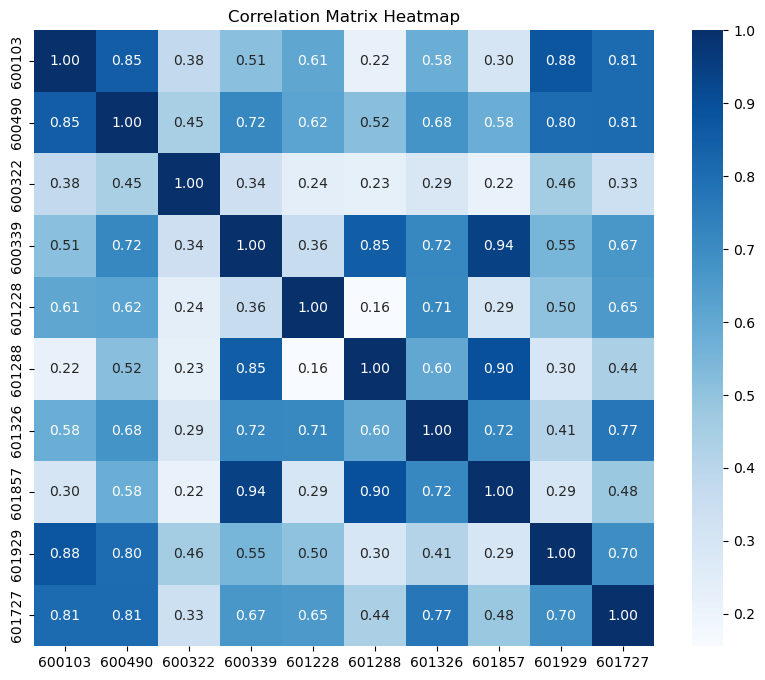

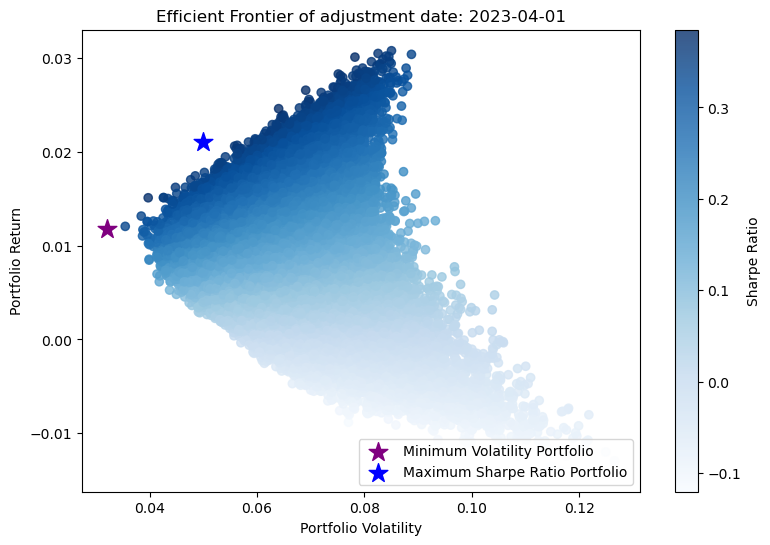

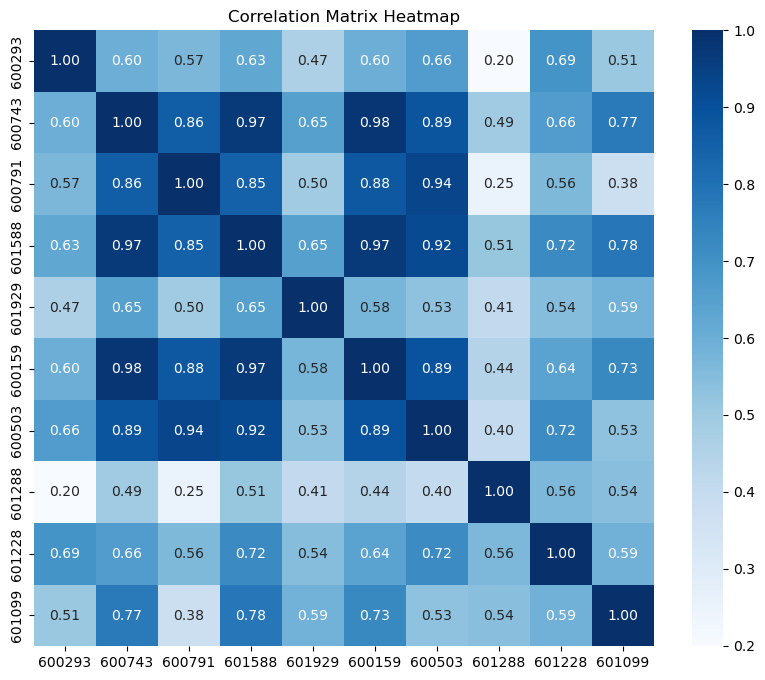

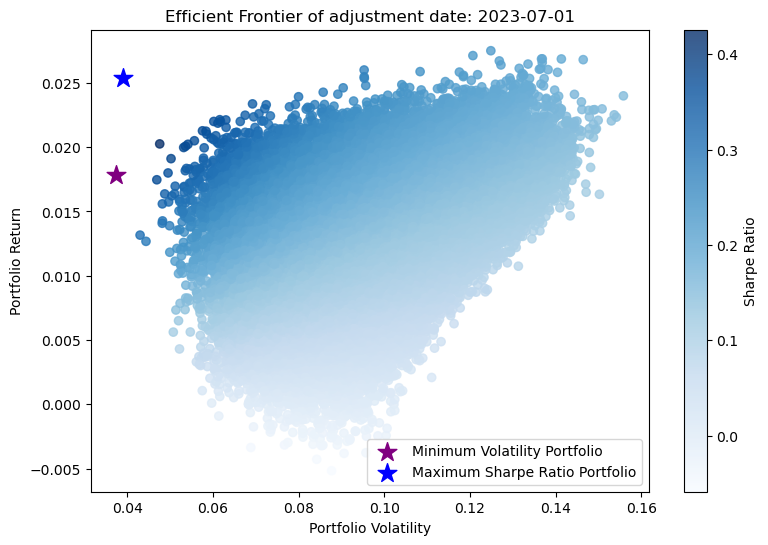

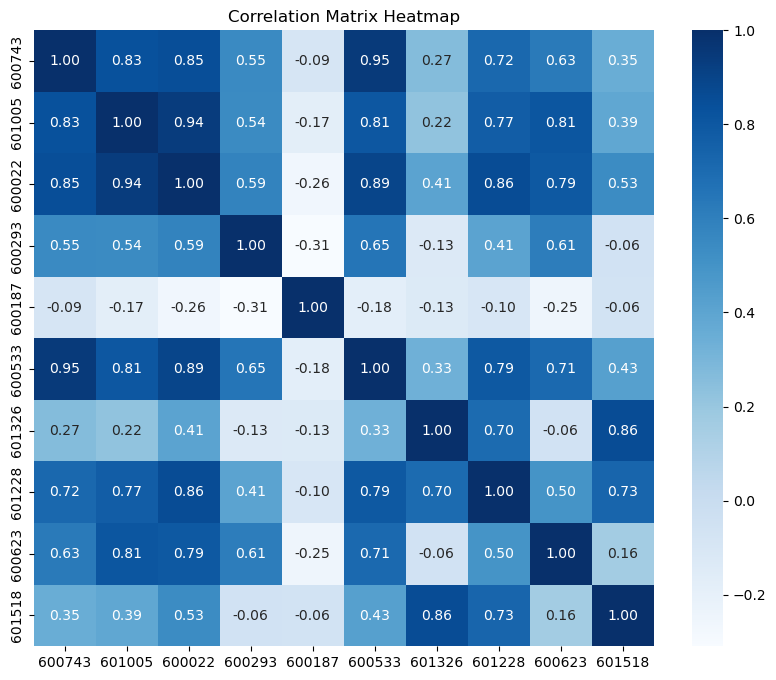

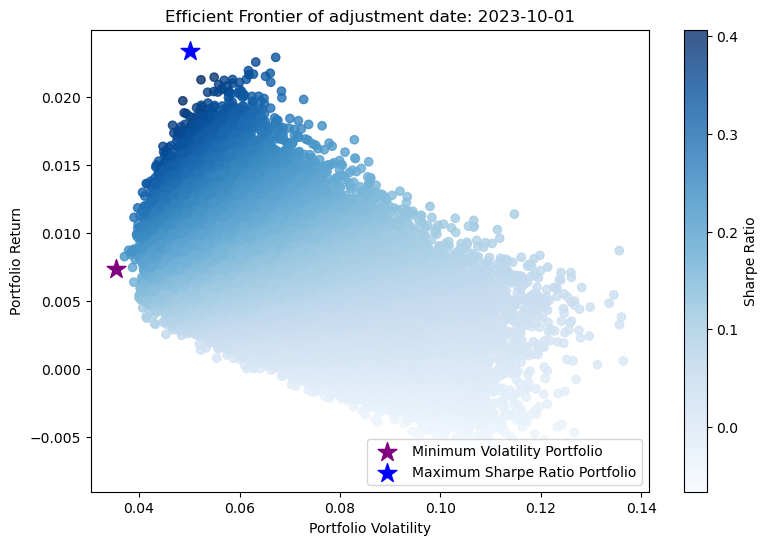

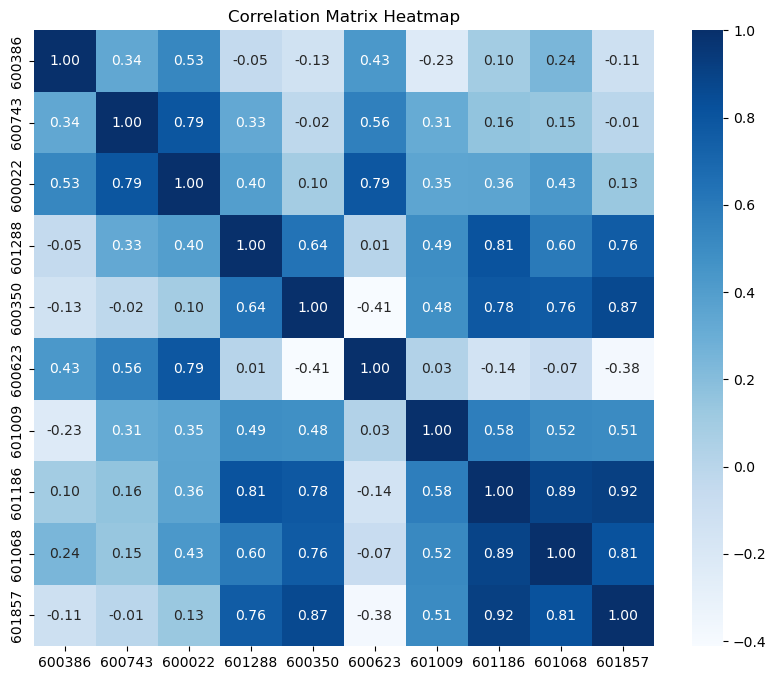

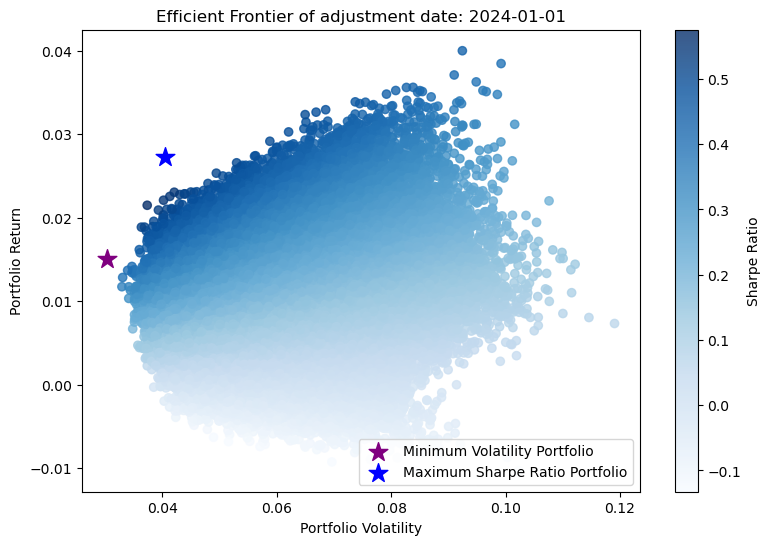

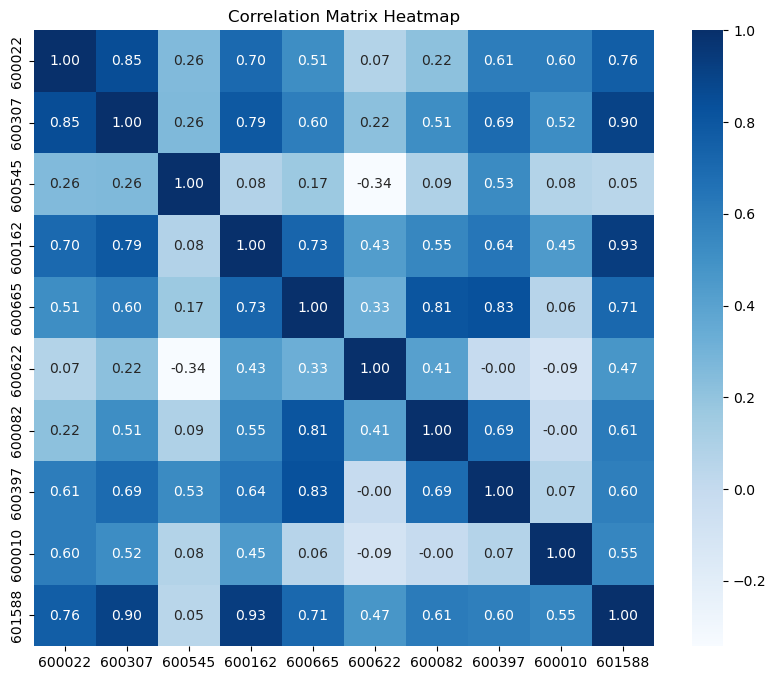

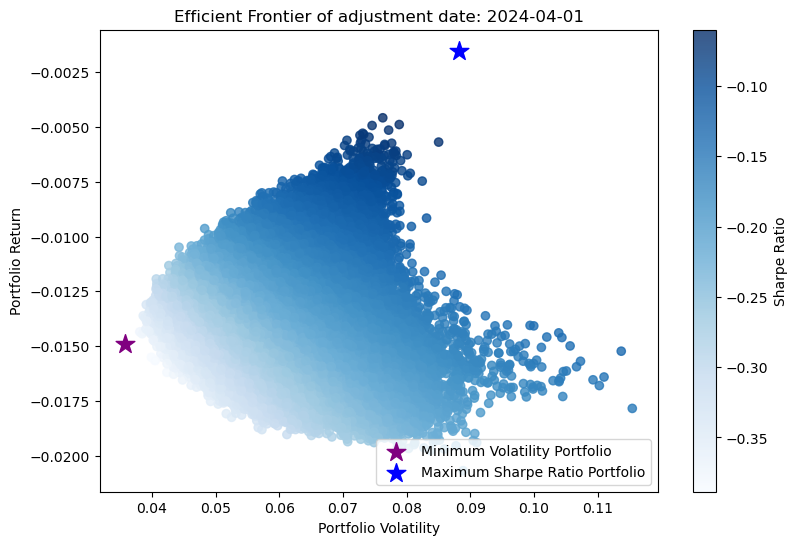

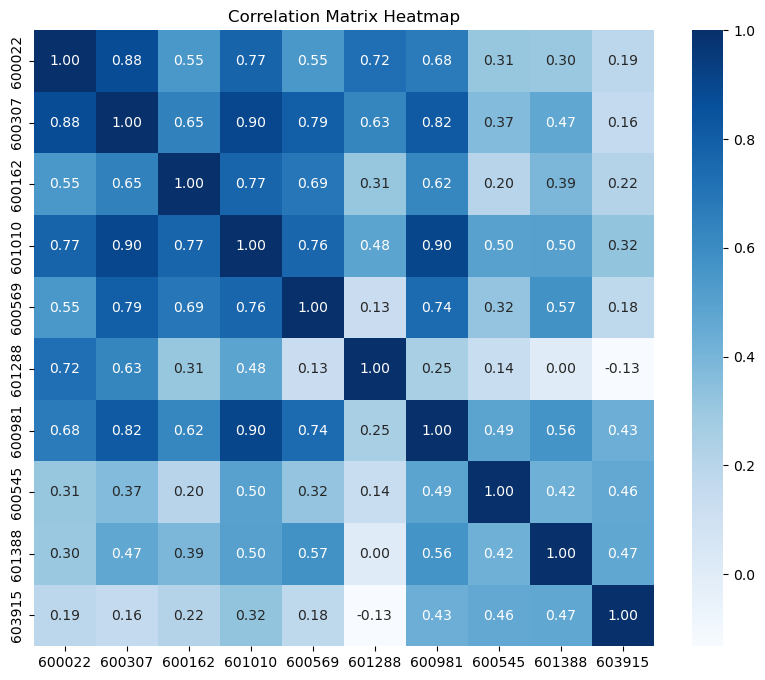

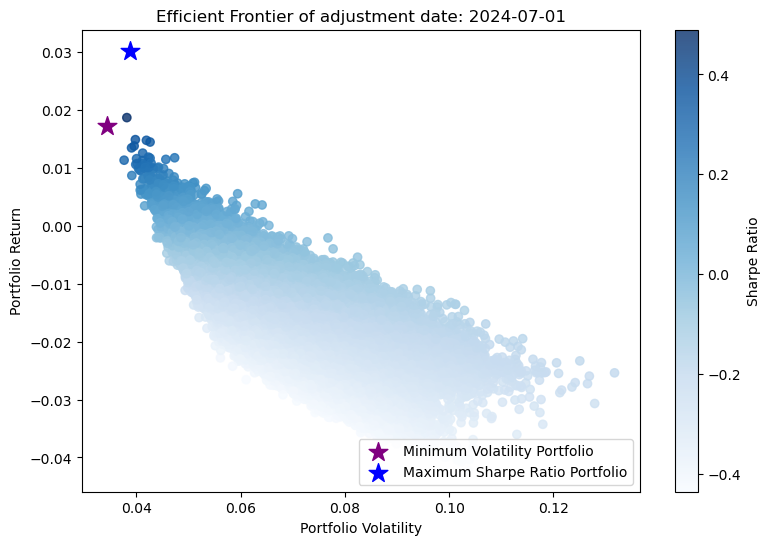

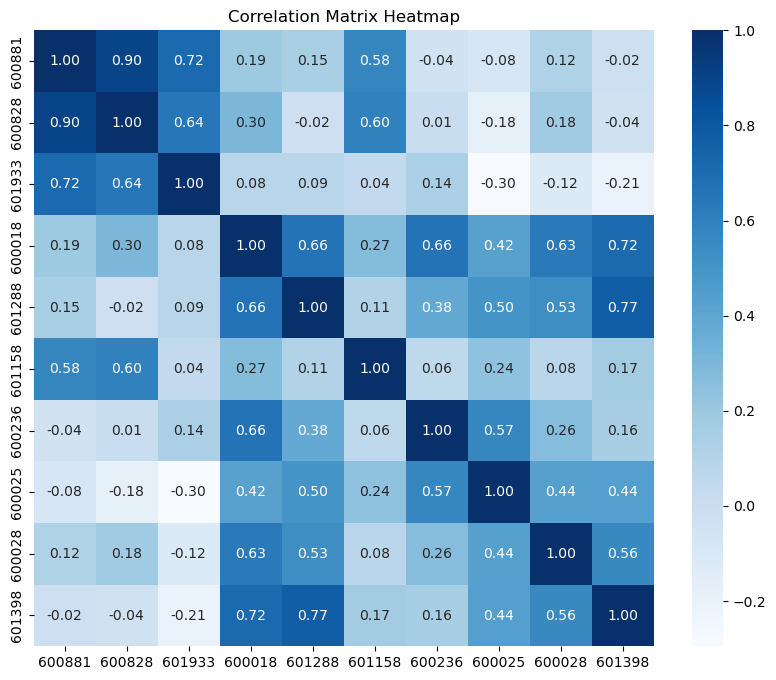

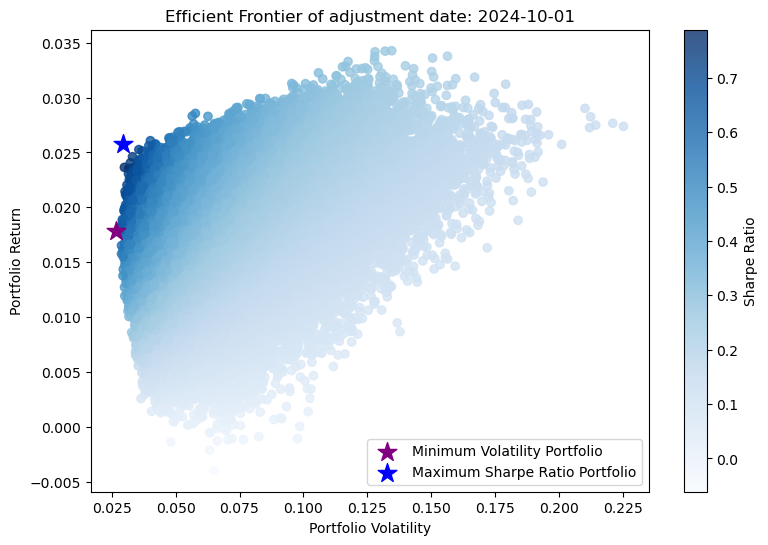

In [18]:
filenames = ["20230103.csv","20230403.csv","20230703.csv","20231009.csv","20240102.csv","20240401.csv","20240701.csv","20241008.csv"]
run_adjustment_efficient_frontier(filenames)